# Recording, training and predicting on data using webcam

### trying to make something like https://teachablemachine.withgoogle.com/v1/

### imports

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
from glob import glob
from copy import deepcopy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cpu


### capturing data

In [5]:
dir_path = 'train_imgs'
if not os.path.exists(dir_path):
  os.makedirs(dir_path)

In [6]:
n_classes = int(input(f'enter number of categories: '))

classes = []
for i in range(n_classes):
  classes.append(input(f'enter the name of class {i}: '))

enter number of categories: 2
enter the name of class 0: bottle
enter the name of class 1: glass


In [7]:
classes

['bottle', 'glass']

In [19]:
for class_ in classes:
  class_img_path = os.path.join(dir_path, class_)
  if not os.path.exists(class_img_path):
    os.makedirs(class_img_path)

In [10]:
cam = cv2.VideoCapture(0)
 
cv2.namedWindow("test")

def show_frame(cam):
  ret, frame = cam.read()
  if not ret:
    print("failed to grab frame")
    return None
  cv2.imshow("test", frame)
  return frame

def save_imgs(class_name, n_imgs=133):
  while True:
    if show_frame(cam) is None:
      break
    
    k = cv2.waitKey(1)
    # SPACE pressed
    if k%256 == 32:
      print('saving images')
      break
  
  
  frame_count, img_counter = 0, 0
  fps = int(cam.get(cv2.CAP_PROP_FPS))
  save_interval = 0.5
  pbar = tqdm(total=n_imgs-1)
  
  while True:
    frame = show_frame(cam)
    if frame is None:
      break
    frame_count += 1
    
    cv2.waitKey(1)
    
    if (frame_count % (fps * save_interval) == 0) or True:
      img_name = os.path.join( dir_path, class_name, f"frame_{img_counter}.png" )
      cv2.imwrite(img_name, frame)
      # print(f"frame_{img_counter} written!")
      img_counter += 1
      pbar.update(1)
      
    if img_counter == n_imgs-1:
      pbar.close()
      break

for class_name in classes:
  print(f'press space to start capturing images for {class_name}')
  save_imgs(class_name)
      
cam.release()

cv2.destroyAllWindows()

press space to start capturing images for bottle
saving images


  0%|          | 0/133 [00:00<?, ?it/s]

press space to start capturing images for glass
saving images


  0%|          | 0/133 [00:00<?, ?it/s]

### getting data

In [27]:
 # Use these transforms with PIL
train_transforms=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

test_transforms=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])


# # Use these trasforms with cv2
# train_transforms = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=350),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
#         A.RandomCrop(height=256, width=256),
#         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
#         A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
#         A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#         A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
#         ToTensorV2(),
#     ]
# )

# test_transforms = A.Compose(
#     [
#         A.Resize(height=256, width=256),
#         A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#         ToTensorV2(),
#     ]
# )

In [28]:
train_data_path = 'train_imgs'

def flatten(l):
    return [item for sublist in l for item in sublist]

train_image_paths = [] #to store image paths in list


for data_path in glob(train_data_path + '/*'):
    train_image_paths.append(glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))


train_image_paths, valid_image_paths = train_test_split(train_image_paths, test_size=0.25, random_state=42)

print("Train size: {}\nValid size: {}\n".format(len(train_image_paths), len(valid_image_paths)))

Train size: 198
Valid size: 66



In [29]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

### creating dataset and dataloaders

In [30]:
class MyCustomDataset(Dataset):
    def __init__(self, image_paths, transforms=False):
        self.image_paths = image_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath)
#         image = cv2.imread(image_filepath)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('\\')[-2]
        label = class_to_idx[label]
        if self.transforms is not None:
            image = self.transforms(image)
#             image = self.transforms(image=image)["image"]
        
        return image, label


train_dataset = MyCustomDataset(train_image_paths,train_transforms)
valid_dataset = MyCustomDataset(valid_image_paths,test_transforms)

In [31]:
train_loader = DataLoader( train_dataset, batch_size=32, shuffle=True )

valid_loader = DataLoader( valid_dataset, batch_size=32, shuffle=False )

dataloaders = {'train':train_loader, 'val':valid_loader}

### neural network

In [32]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT')
model = model.to(device)

Using cache found in C:\Users\er5241/.cache\torch\hub\pytorch_vision_v0.10.0


In [33]:
# adjust the number of output classes in the last layer
model.classifier[-1] = nn.Linear(1280, n_classes)

In [34]:
#Optmizer and loss function
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

In [35]:
def train_model(model,criterion,optimizer,dataloaders,epochs,check_every=None,earlyStopping=False):

  print("training model")
  optimizer.zero_grad()

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  phases = dataloaders.keys()
  valExists = True if "val" in phases else False
  avg_loss = {phase:0 for phase in phases}
  avg_losses = {phase:[] for phase in phases}

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    batchLoss = {phase:[] for phase in phases}

     # Each epoch has a training and validation phase
    for phase in phases:
      if phase == "train":  model.train()  # Set model to training mode
      else: model.eval()   # Set model to evaluate mode
        
      for i, (inputBatch,labelBatch) in enumerate(tqdm(dataloaders[phase], desc=phase, leave=False)):

          inputBatch = inputBatch.to(device).float()
          labelBatch = labelBatch.to(device)
          
          # forward
          with torch.set_grad_enabled(not phase=="val"):
            outputBatch = model(inputBatch)
          loss = criterion(outputBatch, labelBatch)
          batchLoss[phase].append(loss.item())

          # backward + optimize only if in training phase
          if phase == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


    for phase in phases : avg_loss[phase] = np.mean(batchLoss[phase])
        
    phase = "val" if valExists else "train"
    if epoch > 0:
      if avg_loss[phase] < min(avg_losses[phase]):
        best_params = deepcopy(model.state_dict())
        best_epoch, best_loss = epoch, avg_loss[phase]
    else:
      best_params = deepcopy(model.state_dict())
      best_epoch, best_loss = epoch, avg_loss[phase]
      movAvg_old = avg_loss[phase]

    for phase in phases : avg_losses[phase].append(avg_loss[phase])  

    # print statistics
    if epoch % check_every == check_every - 1:
      print("epoch: %d" % (epoch + 1), end="  | ")
      for phase in phases:
        print("%s loss: %.3f" % (phase, avg_loss[phase]), end=", ")
      if check_every > 1:
        print(" | ", end='')
        for phase in phases:        
          print("avg %s loss: %.3f" % (phase, np.mean(avg_losses[phase][epoch+1-check_every:epoch+1])), end=", ")
      if valExists:
        movAvg_new = np.mean(avg_losses["val"][epoch+1-check_every:epoch+1])

      if (valExists) and earlyStopping:
        if movAvg_old < movAvg_new:   break
        else:   movAvg_old = movAvg_new



  end_params = deepcopy(model.state_dict())
  print('Finished Training')
  for phase in phases:  plt.plot(avg_losses[phase], label=phase+" loss")
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params, end_params

training model


  0%|          | 0/5 [00:00<?, ?it/s]

train:   0%|          | 0/7 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

epoch: 1  | train loss: 0.259, val loss: 0.049, 

train:   0%|          | 0/7 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

epoch: 2  | train loss: 0.004, val loss: 0.000, 

train:   0%|          | 0/7 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

epoch: 3  | train loss: 0.001, val loss: 0.000, 

train:   0%|          | 0/7 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

epoch: 4  | train loss: 0.000, val loss: 0.000, 

train:   0%|          | 0/7 [00:00<?, ?it/s]

val:   0%|          | 0/3 [00:00<?, ?it/s]

epoch: 5  | train loss: 0.001, val loss: 0.000, Finished Training


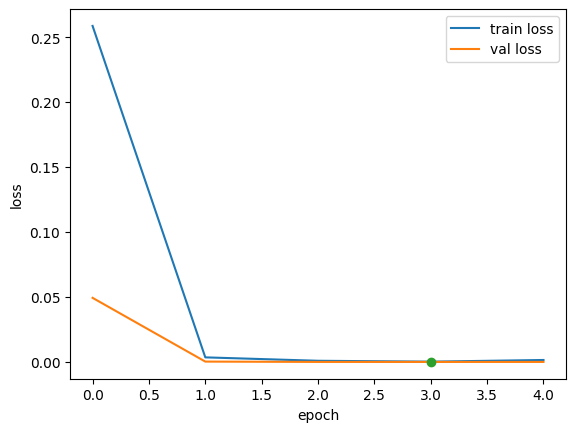

In [36]:
best_params, end_params = train_model(model, criterion, optimizer, dataloaders, 5)

In [37]:
model.load_state_dict(best_params)

<All keys matched successfully>

### testing

In [38]:
cam = cv2.VideoCapture(0)
 
cv2.namedWindow("test")

print('press space to generate prediction')

while True:
  ret, frame = cam.read()
  if not ret:
      print("failed to grab frame")
      break
  cv2.imshow("test", frame)

  k = cv2.waitKey(1)

  if k%256 == 32:
    # SPACE pressed
    img = Image.fromarray(frame)
    img = test_transforms(img)
#     img = test_transforms(image=frame)["image"]
    img = img.unsqueeze(0)
    pred = model(img)
    pred = torch.argmax(pred)
    pred = pred.item()
    if pred in idx_to_class:
      pred = idx_to_class[pred]
      print(pred)
    else:
      print('unknown prediction')

  elif k%256 == 27:
    # ESC pressed
    print("Escape hit, closing...")
    break

cam.release()

cv2.destroyAllWindows()

press space to generate prediction
bottle
bottle
glass
glass
glass
Escape hit, closing...
